# Labeling Bias

This notebook recreates the finding that Equalized Odds constrained model can NOT recover from labeling bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy
import random

# Data + EDA

### Dataset Class

In [2]:
class Dataset:
    def __init__(self, short_name = '', path = '', cat_cols = [], num_cols = [], sep = '', synthetic = False):
        self.short_name = short_name
        self.path = path
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        if not synthetic:
            self.df = pd.read_csv(path, sep = sep)

### Popular Datasets

In [4]:
# each dataset is a dictionary where keys = short name, values = Dataset object

datasets = dict()

def add_dataset(dataset):
    if not isinstance(dataset, Dataset):
        print("Error! Please enter a valid Dataset object")
    else:
        if dataset.short_name not in datasets.keys():
            datasets[dataset.short_name] = dataset

In [5]:
# example - adding a dataset and cleaning it
path_adult_income = 'Datasets/adult.csv'

# note, cat_cols doesn't include predictor - income
cat_cols = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race',
            'gender', 'native-country']
num_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_income = Dataset('adult_income', path_adult_income, cat_cols, num_cols, sep = ",")
add_dataset(adult_income)

In [7]:
cat = ['school', 'sex', 'address','famsize','Pstatus','Mjob','Fjob','reason',
       'guardian','schoolsup','famsup','paid', 'activities','nursery','higher', 'internet','romantic']
num = ['age', 'Medu', 'Fedu','traveltime','studytime','failures', 'famrel',
       'freetime','goout','Dalc','Walc','health','absences','G1', 'G2', 'G3']

add_dataset(Dataset("student_mat", path='Datasets/student-mat.csv', cat_cols=cat, num_cols=num, sep = ";"))
add_dataset(Dataset("student_por", path='Datasets/student-por.csv', cat_cols=cat, num_cols=num, sep = ";"))

### Synthetic Dataset

51.5 % positively labeled


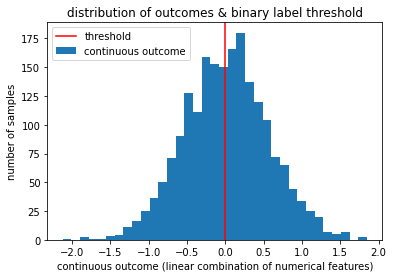

In [8]:
## create synthetic data as such:
# 3 numerical features (Gaussian), 1 categorical (sensitive attribute), 
# linear outcome model, s.t. outcome = Ind[effect_param*features > threshold]

# parameters
threshold = 0 # binary label threshold (outcome > threshold => label=1, else 0)
effect_param = [0.5, -0.2, 0.1] # causal effect parameter (to create outcomes)
n = 2000 # sample size
prop_noise = 0.01 # proportion of noisy binary labels (set to 0 for totally linear)

# categorical feature params
# required: len(cat_probabilities) = n_cat_features
n_cat_features = 2
cat_probabilities = [0.5, 0.5] 

# numerical feature params
num_feature_mean = [0, 0, 0]
num_feature_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# features
num_features = np.random.multivariate_normal(num_feature_mean, num_feature_cov, n)
cat_features = np.random.choice(np.arange(n_cat_features), n, cat_probabilities).reshape(n,1)

# outcomes
outcome_continuous = np.matmul(num_features,effect_param) # linear + no added noise
outcome_binary = np.where(outcome_continuous > threshold, 1, 0).reshape(n,1)

# binary label noise (flip prop_noise labels)
flip_idx = np.random.randint(0,n,int(n*prop_noise))
outcome_binary[flip_idx] = (outcome_binary[flip_idx]-1)*-1

# joint = [numerical features, categorical features, & binary outcome]
joint = np.hstack((num_features, cat_features, outcome_binary))

# print pct of positive labels (to check threshold)
print(round(np.mean(outcome_binary)*100,2), "% positively labeled")

# plot distribution of continuous outcomes & binary threshold 
plt.hist(np.matmul(num_features,effect_param),label='continuous outcome',bins='auto')
plt.axvline(threshold,color='red',label='threshold')
plt.xlabel("continuous outcome (linear combination of numerical features)")
plt.ylabel("number of samples")
plt.title("distribution of outcomes & binary label threshold")
plt.legend()
plt.show()

In [9]:
## add synthetic data to dataset list

# save to file
df_gaussian_synthetic = pd.DataFrame(pd.DataFrame(joint))
df_gaussian_synthetic.columns = ['num1','num2','num3','cat','outcome']
path_gaussian_synthetic = 'Datasets/gaussian_synthetic.csv'
df_gaussian_synthetic.to_csv(path_gaussian_synthetic)

# define Dataset object
cat = df_gaussian_synthetic.columns.values[-1]
num = df_gaussian_synthetic.columns.values[:-2]
gaussian_synthetic = Dataset('gaussian_synthetic', path_gaussian_synthetic, cat_cols=cat, num_cols=num, synthetic=True)

# add to dataset list
add_dataset(gaussian_synthetic)

### EDA

Feel free to use any/all of the following EDA functions and/or add your own!

In [10]:
df_por = datasets['student_por'].df

df_adult = datasets['adult_income'].df
df_adult = df_adult.replace('?', np.NaN)
#print(df_adult.shape)
df_adult = df_adult.dropna()
#print(df_adult.shape)
#df_adult.head()

df_synthetic = df_gaussian_synthetic
#df_synthetic.head()

In [11]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
# plot_counts(df_por, 'sex')

In [12]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
# group_by_plot(df_por, 'sex', 'G3')

In [9]:
# add support for sns.pairplot, plt.scatter, sns.heatmap

# Preparation

### Problem Formulation

In [13]:
# Adult

df_adult["label"] = df_adult["income"].map({'<=50K':0,">50K":1})

df_adult["label"].value_counts()

0    34014
1    11208
Name: label, dtype: int64

In [14]:
def threshold(df, g_1=0.3, g_2=0.3, g_3=0.4, threshold=11):
    """
    Added "pass/fail" to make problem binary classification
    """
    assert g_1 + g_2 + g_3 == 1, "The sum of the percentages should be 1"
    assert 0 < threshold < 20, "Threshold needs to be between 0 and 20"
    df['pass'] = df.apply(lambda row: 1
                                 if g_1*row['G1'] + g_2*row['G2'] + g_3*row['G3'] >= threshold
                                 else 0, axis=1)
threshold(df_por, threshold=14)
df_por['pass'].value_counts()

0    512
1    137
Name: pass, dtype: int64

We will now ask you to identify potential sensitive/protected attributes. Run the chunk below to see the different features in the dataset.

In [15]:
sens_attrs_por = [df_por['sex'], df_por['address']]
sens_attrs_adult = [df_adult['gender'], df_adult['race']]
sens_attrs_syn = [df_synthetic['cat']]

### Data Preprocessing

In [16]:
# format data

X_por = df_por.iloc[:, :-2].values
y_por = df_por.iloc[:, -1].values

X_adult = df_adult.iloc[:, :-2].values
y_adult = df_adult.iloc[:, -1].values

X_syn = df_synthetic.iloc[:, :-1].values
y_syn = df_synthetic.iloc[:, -1].values

In [17]:
# OHE categorical features (prompt for user's choice here?)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# get indices of categorical columns
def get_cat_cols(dataset):
    df = dataset.df
    res = []
    for col in dataset.cat_cols:
        res.append(df.columns.get_loc(col))
    return res

cat_cols_por = get_cat_cols(datasets['student_por'])
cat_cols_adult = get_cat_cols(datasets['adult_income'])

ct_por = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols_por)], remainder='passthrough')

X_por = np.array(ct_por.fit_transform(X_por))

In [18]:
df_temp = df_adult.copy().drop("income", axis = 1)
df_temp = df_temp.drop("label", axis = 1)
#print("Before", df_temp.shape)

for cat_col in datasets['adult_income'].cat_cols:
    encoded = pd.get_dummies(df_temp[cat_col])
    df_temp = df_temp.drop(cat_col, axis = 1)
    df_temp = df_temp.join(encoded)

#print("After", df_temp.shape)

df_temp = df_temp.join(df_adult['label'])

X_adult = np.array(df_temp.drop('label', axis = 1).values)

In [19]:
X_por_true = X_por
y_por_true = df_por['pass']

X_adult_true = X_adult
y_adult_true = df_adult['label']


X_syn_true = X_syn
y_syn_true = y_syn

# Bias Injection

### Class Distribution Visualization

In [31]:
#df_por.shape
print(df_por['address'].value_counts(), "\n")
print(df_por['sex'].value_counts(), "\n")

print(df_adult['race'].value_counts(), "\n")
print(df_adult['gender'].value_counts())

U    452
R    197
Name: address, dtype: int64 

F    383
M    266
Name: sex, dtype: int64 

White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64 

Male      30527
Female    14695
Name: gender, dtype: int64


<AxesSubplot:>

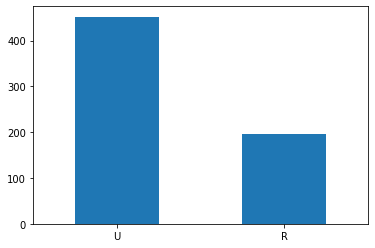

In [16]:
count = pd.value_counts(df_por['address'], sort = True)
count.plot(kind = 'bar', rot = 0)

### Bias Injection

In [22]:
# separate based on protected attribute
sens_values = sens_attrs_por[1].unique()

# TODO - add prompt for user to specify which value is favored and which is unfavored

df_favored_por = df_por[df_por['address'] == 'U']
df_unfavored_por = df_por[df_por['address'] == 'R']

df_favored_adult = df_adult[df_adult['gender'] == 'Male']
df_unfavored_adult = df_adult[df_adult['gender'] == 'Female']

df_favored_syn = df_synthetic[df_synthetic['cat'] == 0]
df_unfavored_syn = df_synthetic[df_synthetic['cat'] == 1]

In [23]:
# unfavored group with negative label
df_unfavored_por_negative = df_unfavored_por[df_unfavored_por['pass'] == 0]
df_unfavored_adult_negative = df_unfavored_adult[df_unfavored_adult['label'] == 0]
df_unfavored_syn_negative = df_unfavored_syn[df_unfavored_syn['outcome'] == 0.0]


# unfavored group with positive label (preferred)
df_unfavored_por_positive = df_unfavored_por[df_unfavored_por['pass'] == 1]
df_unfavored_adult_positive = df_unfavored_adult[df_unfavored_adult['label'] == 1]
df_unfavored_syn_positive = df_unfavored_syn[df_unfavored_syn['outcome'] == 1.0]

# differences in label counts for unfavored group
df_unfavored_por['pass'].value_counts()

df_total_por = pd.concat([df_favored_por, df_unfavored_por_negative])
df_total_adult = pd.concat([df_favored_adult, df_unfavored_adult_negative])
df_total_syn = pd.concat([df_favored_syn, df_unfavored_syn_negative])

In [28]:
# simulate random flipping of labels

seed = 42
random.choice(list(range(1,11)))

df_por_bias = copy.copy(df_unfavored_por_positive)
df_adult_bias = copy.copy(df_unfavored_adult_positive)
df_syn_bias = copy.copy(df_unfavored_syn_positive)

for index in df_por_bias.index:
    seed += 5
    random.seed(seed)
    rand = random.choice(list(range(1,11)))
    if rand <= 5:
        df_por_bias.at[index, 'pass'] = 0
        
for index in df_adult_bias.index:
    seed += 5
    random.seed(seed)
    rand = random.choice(list(range(1,11)))
    if rand <= 5:
        df_adult_bias.at[index, 'label'] = 0
        
for index in df_syn_bias.index:
    seed += 5
    random.seed(seed)
    rand = random.choice(list(range(1,11)))
    if rand <= 5:
        df_syn_bias.at[index, 'outcome'] = 0
        
print(df_unfavored_por_positive['pass'].value_counts(), "\n", df_por_bias['pass'].value_counts())

print("\n")
print(df_unfavored_adult_positive['label'].value_counts(), "\n", df_adult_bias['label'].value_counts())

print("\n")
print(df_unfavored_syn_positive['outcome'].value_counts(), "\n", df_syn_bias['outcome'].value_counts())

1    31
Name: pass, dtype: int64 
 0    16
1    15
Name: pass, dtype: int64


1    1669
Name: label, dtype: int64 
 0    846
1    823
Name: label, dtype: int64


1.0    525
Name: outcome, dtype: int64 
 1.0    264
0.0    261
Name: outcome, dtype: int64


In [32]:
# combine undersampled and original favored class to create dataset
df_concat_por = pd.concat([df_total_por,df_por_bias])
df_concat_adult = pd.concat([df_total_adult,df_adult_bias])
df_concat_syn = pd.concat([df_total_syn,df_syn_bias])

# for fairness measures later
df_sens_por = df_concat_por['address']
df_sens_adult = df_concat_adult['gender']
df_sens_syn = df_concat_syn['cat']

# format data
X_por_bias = df_concat_por.iloc[:, :-2].values
y_por_bias = df_concat_por.iloc[:, -1].values
X_adult_bias = df_concat_adult.iloc[:, :-2].values
y_adult_bias = df_concat_adult.iloc[:, -1].values
X_syn_bias = df_concat_syn.iloc[:, :-1].values
y_syn_bias = df_concat_syn.iloc[:, -1].values

# OHE
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols_por)], remainder='passthrough')
X_por_bias_true = np.array(ct.fit_transform(X_por_bias))
y_por_bias_true = df_concat_por['pass']


df_temp = df_concat_adult.copy().drop("income", axis = 1)
df_temp = df_temp.drop("label", axis = 1)

for cat_col in datasets['adult_income'].cat_cols:
    encoded = pd.get_dummies(df_temp[cat_col])
    df_temp = df_temp.drop(cat_col, axis = 1)
    df_temp = df_temp.join(encoded)

df_temp = df_temp.join(df_concat_adult['label'])

X_adult_bias_true = np.array(df_temp.drop('label', axis = 1).values)
y_adult_bias_true = df_concat_adult['label']


X_syn_bias_true = X_syn_bias
y_syn_bias_true = y_syn_bias

print(X_por_true.shape, X_por_bias_true.shape)
print(X_adult_true.shape, X_adult_bias_true.shape)
print(X_syn_true.shape, X_syn_bias_true.shape)
#print(y_true.value_counts(), "\n\n", y_bias_true.value_counts())

(649, 58) (649, 58)
(45222, 104) (45222, 104)
(2000, 4) (2000, 4)



### Post-Injection Visualization

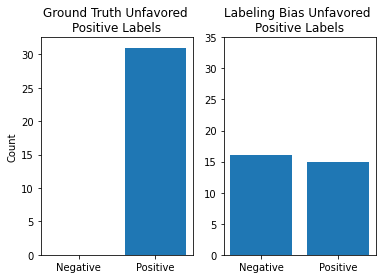

In [21]:
true_negative = 0
true_positive = df_unfavored_positive['pass'].value_counts()[1]
bias_negative = df_bias['pass'].value_counts()[0]
bias_positive = df_bias['pass'].value_counts()[1]

x_vals = ['Negative', "Positive"]
y_vals_true = [true_negative, true_positive]
y_vals_bias = [bias_negative, bias_positive]

plt.subplot(1,2,1)
plt.bar(x_vals, y_vals_true)
plt.title("Ground Truth Unfavored \nPositive Labels")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.bar(x_vals, y_vals_bias)
plt.title("Labeling Bias Unfavored \nPositive Labels")
plt.ylim([0,35])

plt.show()

# Model

### Model Selection + Training (TODO: modularize)

In [33]:
# modularize and add data struct of different ml techniques

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 42)

# Student Performance
classifier_por_true = classifier.fit(X_por_true, y_por_true)
y_por_pred_truth = classifier_por_true.predict(X_por_true)

classifier_por_bias = classifier.fit(X_por_bias_true, y_por_bias_true)
y_por_pred_bias = classifier_por_bias.predict(X_por_bias_true)
y_por_pred_bias_on_true = classifier_por_bias.predict(X_por_true)


# Adult Income
classifier_adult_true = classifier.fit(X_adult_true, y_adult_true)
y_adult_pred_truth = classifier_adult_true.predict(X_adult_true)

classifier_adult_bias = classifier.fit(X_adult_bias_true, y_adult_bias_true)
y_adult_pred_bias = classifier_adult_bias.predict(X_adult_bias_true)
y_adult_pred_bias_on_true = classifier_adult_bias.predict(X_adult_true)


# Synthetic Data
classifier_syn_true = classifier.fit(X_syn_true, y_syn_true)
y_syn_pred_truth = classifier_syn_true.predict(X_syn_true)

classifier_syn_bias = classifier.fit(X_syn_bias_true, y_syn_bias_true)
y_syn_pred_bias = classifier_syn_bias.predict(X_syn_bias_true)
y_syn_pred_bias_on_true = classifier_syn_bias.predict(X_syn_true)

### Model Performance (TODO: modularize)

In [34]:
print("Student Performance")

print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_por_pred_truth, y_por_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_por_pred_bias, y_por_bias_true))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_por_pred_bias_on_true, y_por_true))

print("\nAdult Income")

print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_adult_pred_truth, y_adult_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_adult_pred_bias, y_adult_bias_true))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_adult_pred_bias_on_true, y_adult_true))

print("\nSynthetic Data")

print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_syn_pred_truth, y_syn_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_syn_pred_bias, y_syn_bias_true))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_syn_pred_bias_on_true, y_syn_true))

Student Performance
Accuracy of Ground Truth Model on Ground Truth Data:  0.9938366718027735
Accuracy of Biased Model on Biased Data:  0.9953775038520801
Accuracy of Biased Model on Ground Truth Data:  0.9738058551617874

Adult Income
Accuracy of Ground Truth Model on Ground Truth Data:  0.9780858873999381
Accuracy of Biased Model on Biased Data:  0.9785502631462563
Accuracy of Biased Model on Ground Truth Data:  0.9610366635708284

Synthetic Data
Accuracy of Ground Truth Model on Ground Truth Data:  0.993
Accuracy of Biased Model on Biased Data:  0.9815
Accuracy of Biased Model on Ground Truth Data:  0.865


Thus, we can see that under-sampling decreases model performance on the ground truth data.

In [24]:
# Ground Truth Model on Ground Truth Data

gm_true = MetricFrame(accuracy_score, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_true.overall)
print("Group Accuracy : ", gm_true.by_group)

print("\n")

sr_true = MetricFrame(selection_rate, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_true.overall)
print("Group Selection Rate : ", sr_true.by_group)

Overall Accuracy:  0.9845916795069337
Group Accuracy :  address
R    0.979695
U    0.986726
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.2110939907550077
Group Selection Rate :  address
R    0.177665
U    0.225664
Name: selection_rate, dtype: object


Thus, we can see that there is a **5% discrepancy** in the selection rate for Rural vs Urban students (with Urban students being preferred)

In [25]:
# Biased Model on Biased Data

gm_bias = MetricFrame(accuracy_score, y_bias_true, y_pred_bias, sensitive_features = df_sens)
print("Overall Accuracy: ", gm_bias.overall)
print("Group Accuracy : ", gm_bias.by_group)

print("\n")

sr_bias = MetricFrame(selection_rate, y_bias_true, y_pred_bias, sensitive_features = df_sens)
print("Overall Selection Rate: ", sr_bias.overall)
print("Group Selection Rate : ", sr_bias.by_group)

Overall Accuracy:  0.9707241910631741
Group Accuracy :  address
R    0.954315
U    0.977876
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.19722650231124808
Group Selection Rate :  address
R    0.071066
U    0.252212
Name: selection_rate, dtype: object


Thus, we can see that there is now a **18% discrepancy due to under-sampling** in the selection rate for Rural vs Urban students (with Urban students being preferred) on biased data

In [26]:
# Biased Model on Ground Truth Data

gm_bias_on_true = MetricFrame(accuracy_score, y_true,
                           y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_bias_on_true.overall)
print("Group Accuracy : ", gm_bias_on_true.by_group)

print("\n")

sr_bias_on_true = MetricFrame(selection_rate, y_true,
                              y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_bias_on_true.overall)
print("Group Selection Rate : ", sr_bias_on_true.by_group)

Overall Accuracy:  0.9553158705701078
Group Accuracy :  address
R    0.903553
U    0.977876
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.19722650231124808
Group Selection Rate :  address
R    0.071066
U    0.252212
Name: selection_rate, dtype: object


Thus, we see that the biased model has lower overall and subgroup accuracy on the ground truth data. 
Also, we can observe that the selection rate disparity increased ever so slightly with the biased model.

In [27]:
print("Ground Truth Model on Ground Truth Data")

print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("\n")

print("Biased Model on Ground Truth Data")

print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))

Ground Truth Model on Ground Truth Data
EOD: 0.047169811320754707
DPD: 0.04799874219486994
EOR: 0.11994219653179189
DPR: 0.7872996914501842


Biased Model on Ground Truth Data
EOD: 0.5712111990261717
DPD: 0.18114639953281525
EOR: 0.23159303882195448
DPR: 0.28177041588743434


# Fairness Intervention

In [23]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
np.random.seed(0)

#### Student Performance

In [35]:
constraint = EqualizedOdds()
mitigator_por_true = ExponentiatedGradient(classifier_por_true, constraint)
mitigator_por_true.fit(X_por_true, y_por_true, sensitive_features = sens_attrs_por[1])
y_por_pred_mitigated_true = mitigator_por_true.predict(X_por_true)

In [36]:
constraint = EqualizedOdds()
mitigator_por_bias = ExponentiatedGradient(classifier_por_bias, constraint)
mitigator_por_bias.fit(X_por_bias_true, y_por_bias_true, sensitive_features = df_sens_por)
y_por_pred_mitigated_bias = mitigator_por_bias.predict(X_por_bias_true)
y_por_pred_mitigated_bias_on_true = mitigator_por_bias.predict(X_por_true)

#### Adult Income

In [37]:
constraint = EqualizedOdds()
mitigator_adult_true = ExponentiatedGradient(classifier_adult_true, constraint)
mitigator_adult_true.fit(X_adult_true, y_adult_true, sensitive_features = sens_attrs_adult[0])
y_adult_pred_mitigated_true = mitigator_adult_true.predict(X_adult_true)

In [38]:
constraint = EqualizedOdds()
mitigator_adult_bias = ExponentiatedGradient(classifier_adult_bias, constraint)
mitigator_adult_bias.fit(X_adult_bias_true, y_adult_bias_true, sensitive_features = df_sens_adult)
y_adult_pred_mitigated_bias = mitigator_adult_bias.predict(X_adult_bias_true)
y_adult_pred_mitigated_bias_on_true = mitigator_adult_bias.predict(X_adult_true)

#### Synthetic Data

In [39]:
constraint = EqualizedOdds()
mitigator_syn_true = ExponentiatedGradient(classifier_syn_true, constraint)
mitigator_syn_true.fit(X_syn_true, y_syn_true, sensitive_features = sens_attrs_syn[0])
y_syn_pred_mitigated_true = mitigator_syn_true.predict(X_syn_true)

In [40]:
constraint = EqualizedOdds()
mitigator_syn_bias = ExponentiatedGradient(classifier_syn_bias, constraint)
mitigator_syn_bias.fit(X_syn_bias_true, y_syn_bias_true, sensitive_features = df_sens_syn)
y_syn_pred_mitigated_bias = mitigator_syn_bias.predict(X_syn_bias_true)
y_syn_pred_mitigated_bias_on_true = mitigator_syn_bias.predict(X_syn_true)

# Evaluation

In [31]:
# TODO: create data structure of different ml performance metrics
#       get user input and modularize output shown

In [41]:
print("Student Performance")

print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_por_pred_mitigated_true, y_por_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_por_pred_mitigated_bias_on_true, y_por_true))

print("\nAdult Income")

print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_adult_pred_mitigated_true, y_adult_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_adult_pred_mitigated_bias_on_true, y_adult_true))

print("\nSynthetic Data")

print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_syn_pred_mitigated_true, y_syn_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_syn_pred_mitigated_bias_on_true, y_syn_true))

Student Performance
Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.9984591679506933
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.9676425269645609

Adult Income
Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.9755207642297996
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.9514395648135863

Synthetic Data
Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.9955
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.862


In [33]:
# Ground Truth Model + Fairness Intervention on Ground Truth Data

gm_mitigated = MetricFrame(accuracy_score, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)

print("\n")

sr_mitigated = MetricFrame(selection_rate, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

Overall Accuracy:  0.9691833590138675
Group Accuracy :  address
R    0.928934
U    0.986726
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.22650231124807396
Group Selection Rate :  address
R    0.228426
U    0.225664
Name: selection_rate, dtype: object


In [34]:
# Biased Model + Fairness Intervention on Ground Truth Data

gm_mitigated_bias_on_true = MetricFrame(accuracy_score, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated_bias_on_true.overall)
print("Group Accuracy : ", gm_mitigated_bias_on_true.by_group)

print("\n")

sr_mitigated_bias_on_true = MetricFrame(selection_rate, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated_bias_on_true.overall)
print("Group Selection Rate : ", sr_mitigated_bias_on_true.by_group)

Overall Accuracy:  0.9768875192604006
Group Accuracy :  address
R    0.949239
U    0.988938
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.2218798151001541
Group Selection Rate :  address
R    0.208122
U    0.227876
Name: selection_rate, dtype: object


Hence, we observe an increase in overall and subgroup accuracy, but a decrease in disadvantaged subgroup selection rate

### Bias vs Accuracy vs Fairness Trade-Off

In [68]:
# simulate random flipping of labels
def labeling_bias(df_unfavored_positive, label = "", prob = 0.5):
    #assert(isinstance(prob*10, int)), "Please enter a floating point number from 0.0 - 1.0 representing the probability (to the tenths)"
    
    seed = 42
    random.choice(list(range(1,11)))

    df_bias = copy.copy(df_unfavored_positive)

    for index in df_bias.index:
        seed += 5
        random.seed(seed)
        rand = random.choice(list(range(1,11)))
        if rand <= prob*10:
            df_bias.at[index, label] = 0
    return df_bias

    # print(df_unfavored_positive['pass'].value_counts(), "\n", df_bias['pass'].value_counts())

In [69]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairnedf_unfavored_positives fairness intervention
def tradeoff_visualization(classifier, X_true, y_true, df_favored,
                           df_unfavored_positive, df_unfavored_negative,
                           sensitive_feature = "sex", is_adult = False,
                           label = "label", cat_cols = [], synthetic = False,
                           apply_fairness = False, verbose = False):
    
    bias_amts = np.divide(list(range(0,11)), 10).tolist()
    accuracy_on_true = []
    accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []
    eod_on_true = []
    eod_on_biased = []
    eod_on_true_mitigated = []
    dataset_size_true = np.full(shape=len(bias_amts), fill_value= X_true.shape[0]).tolist()
    dataset_size_bias = []

    classifier_true = classifier.fit(X_true, y_true)
    y_pred_truth = classifier_true.predict(X_true)

    for prob in bias_amts:
        # labeling bias process
        df_bias = labeling_bias(df_unfavored_positive, label = label, prob=prob)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_favored, df_unfavored_negative, df_bias])
        df_concat.shape
        df_sens = df_concat[sensitive_feature]

        # format data
        X_bias = df_concat.iloc[:, :-2].values
        y_bias = df_concat.iloc[:, -1].values

        # OHE
        
        if is_adult:
            df_temp = df_concat.copy().drop("income", axis = 1)
            df_temp = df_temp.drop("label", axis = 1)
            for cat_col in datasets['adult_income'].cat_cols:
                encoded = pd.get_dummies(df_temp[cat_col])
                df_temp = df_temp.drop(cat_col, axis = 1)
                df_temp = df_temp.join(encoded)
            df_temp = df_temp.join(df_concat['label'])
            X_bias_true = np.array(df_temp.drop('label', axis = 1).values)
            y_bias_true = df_concat['label']
        else:
            if not synthetic:
                ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
                X_bias_true = np.array(ct.fit_transform(X_bias))
                y_bias_true = df_concat[label]
            else:
                X_bias_true = df_concat.iloc[:, :-1].values
                y_bias_true = df_concat.iloc[:, -1].values
        
        dataset_size_bias.append(X_bias_true.shape[0])
        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = EqualizedOdds()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        '''

        # fairness performance

        eod_true = equalized_odds_difference(y_true=y_bias_true, y_pred = y_pred_bias, sensitive_features=df_sens)
        eod_on_true.append(eod_true)

        eod_bias_on_true = equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1])
        eod_on_biased.append(eod_bias_on_true)

        eod_bias_true_mitigated = equalized_odds_difference(y_true=y_true,\
        y_pred = y_pred_mitigated_bias_on_true, sensitive_features=sens_attrs[1])
        eod_on_true_mitigated.append(eod_bias_true_mitigated)
        
        '''
        
        if verbose:
            print("Finished Iteration: ", prob)

    return bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased,\
           accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated

In [80]:
def accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias,
                            accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False):
    
    if fairness:
        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of positive minority samples flipped)")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        #plt.ylim(0.97, 0.99)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
        plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of positive minority samples flipped)")
        plt.ylabel("Dataset Size")
        plt.legend()

        plt.show()
        
    else:
        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of positive minority samples flipped)")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        #plt.ylim(0.97, 0.99)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
        plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of positive minority samples flipped)")
        plt.ylabel("Dataset Size")
        plt.legend()

        plt.show()

In [81]:
def total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated,
                        dataset_size_true, dataset_size_bias):
    plt.figure(figsize=(17,7))

    plt.subplot(1,2,1)
    plt.plot(bias_amts, accuracy_on_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.plot(bias_amts, accuracy_on_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    plt.xlabel("Amount of Bias (number of positive minority samples flipped)")
    plt.ylabel("Accuracy Score")
    #plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model On Ground Truth Data", alpha = 0.5)
    plt.title("Accuracy of Biased Model (trained on biased data)")
    plt.legend(loc = 3)

    plt.subplot(1,2,2)
    plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
    plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
    plt.xlabel("Amount of Bias (number of positive minority samples flipped)")
    plt.ylabel("Dataset Size")
    plt.title("Amount of Minority Samples Removed vs Dataset Size")
    plt.legend()

    plt.show()

In [89]:
classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 42)

bias_amts, dataset_size_true, dataset_size_bias, \
accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated = \
tradeoff_visualization(classifier, X_true=X_por_true, y_true=y_por_true, \
                       df_favored=df_favored_por, df_unfavored_positive= df_unfavored_por_positive,\
                       df_unfavored_negative= df_unfavored_por_negative, sensitive_feature="address",\
                       cat_cols=get_cat_cols(datasets['student_por']), is_adult=False, label = "pass",\
                       apply_fairness=True,verbose=True)

Finished Iteration:  0.0
Finished Iteration:  0.1
Finished Iteration:  0.2
Finished Iteration:  0.3
Finished Iteration:  0.4
Finished Iteration:  0.5
Finished Iteration:  0.6
Finished Iteration:  0.7
Finished Iteration:  0.8
Finished Iteration:  0.9
Finished Iteration:  1.0


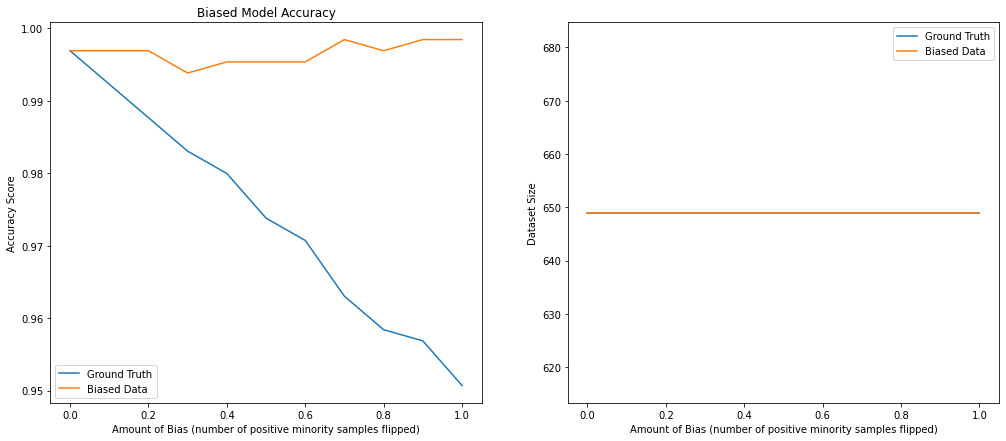

In [90]:
# without fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, False)

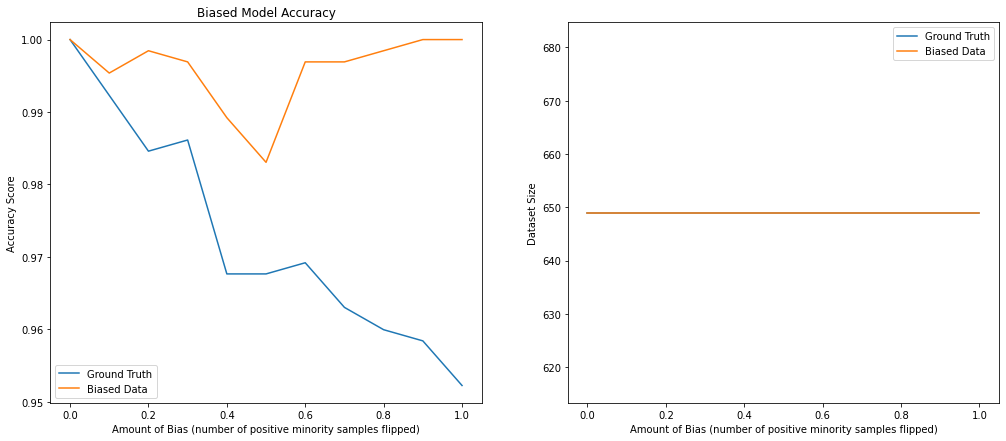

In [91]:
# with fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, True)

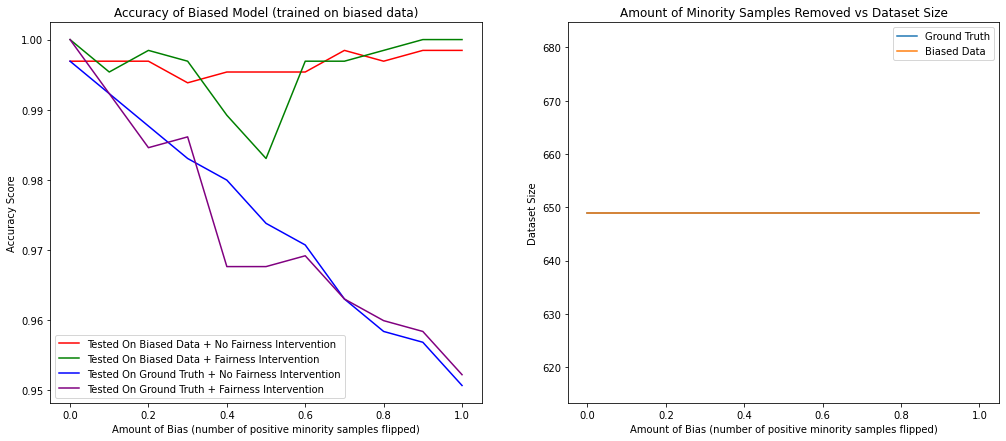

In [92]:
total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                    accuracy_on_biased_mitigated, accuracy_on_true_mitigated,
                    dataset_size_true, dataset_size_bias)

In [74]:
classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 42)

bias_amts, dataset_size_true, dataset_size_bias, \
accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated = \
tradeoff_visualization(classifier, X_true=X_adult_true, y_true=y_adult_true, \
                       df_favored=df_favored_adult, df_unfavored_positive= df_unfavored_adult_positive,\
                       df_unfavored_negative= df_unfavored_adult_negative, sensitive_feature="gender",
                       is_adult=True, label = "label", apply_fairness=True,verbose=True)

Finished Iteration:  0.0
Finished Iteration:  0.1
Finished Iteration:  0.2
Finished Iteration:  0.3
Finished Iteration:  0.4
Finished Iteration:  0.5
Finished Iteration:  0.6
Finished Iteration:  0.7
Finished Iteration:  0.8
Finished Iteration:  0.9
Finished Iteration:  1.0


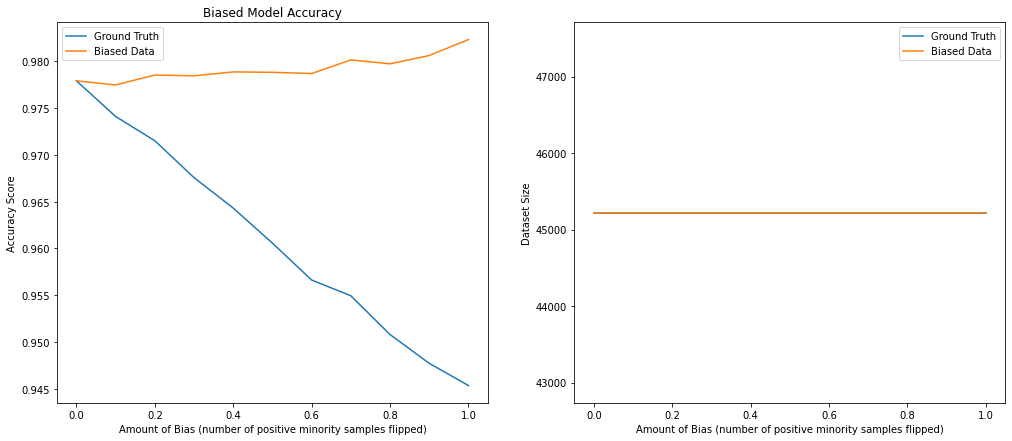

In [82]:
# without fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, False)

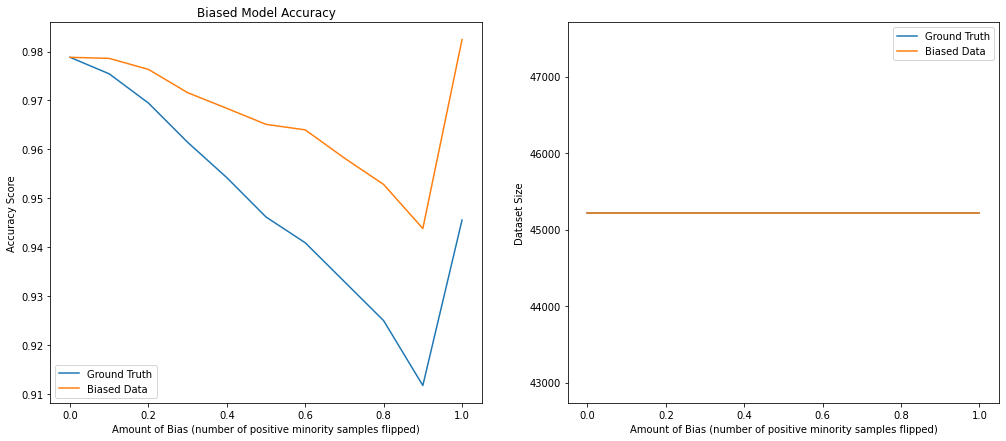

In [83]:
# with fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, True)

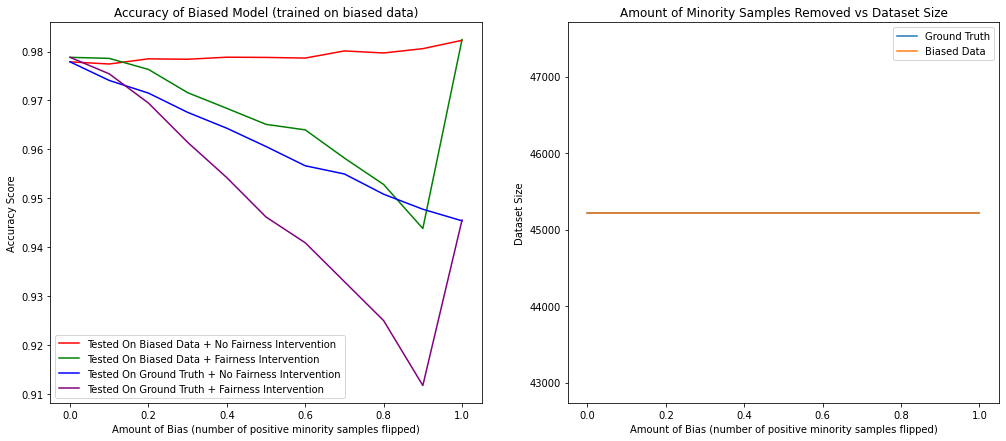

In [84]:
total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                    accuracy_on_biased_mitigated, accuracy_on_true_mitigated,
                    dataset_size_true, dataset_size_bias)

In [85]:
classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 42)

bias_amts, dataset_size_true, dataset_size_bias, \
accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated = \
tradeoff_visualization(classifier, X_true=X_syn_true, y_true=y_syn_true, \
                       df_favored=df_favored_syn, df_unfavored_positive= df_unfavored_syn_positive,\
                       df_unfavored_negative= df_unfavored_syn_negative, sensitive_feature="cat",\
                       cat_cols=[3], is_adult=False, label = "outcome", synthetic = True,\
                       apply_fairness=True,verbose=True)

Finished Iteration:  0.0
Finished Iteration:  0.1
Finished Iteration:  0.2
Finished Iteration:  0.3
Finished Iteration:  0.4
Finished Iteration:  0.5
Finished Iteration:  0.6
Finished Iteration:  0.7
Finished Iteration:  0.8
Finished Iteration:  0.9
Finished Iteration:  1.0


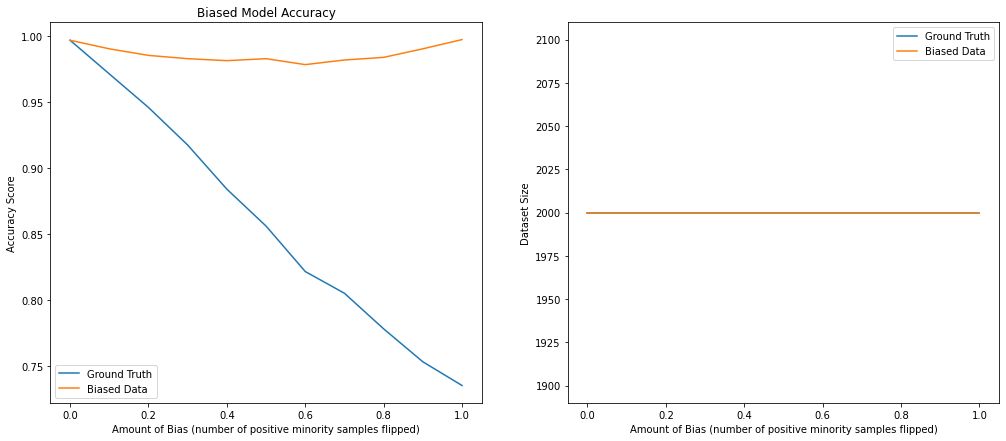

In [86]:
# without fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, False)

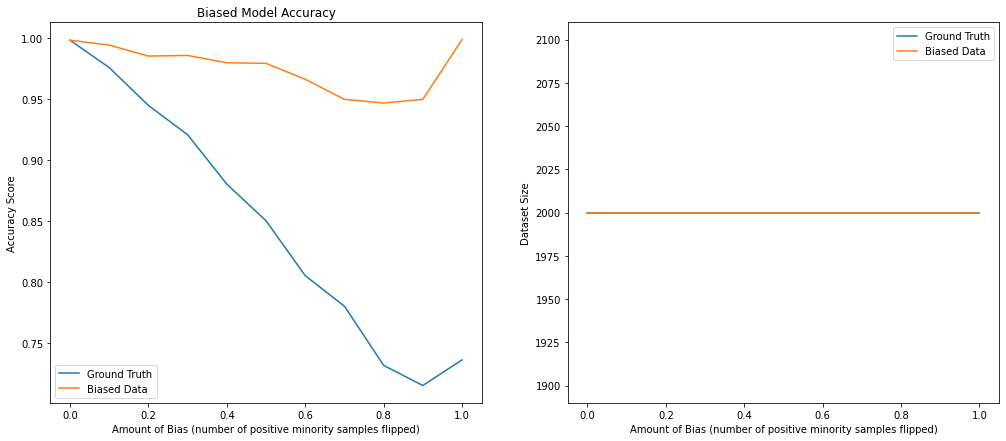

In [87]:
# with fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, True)

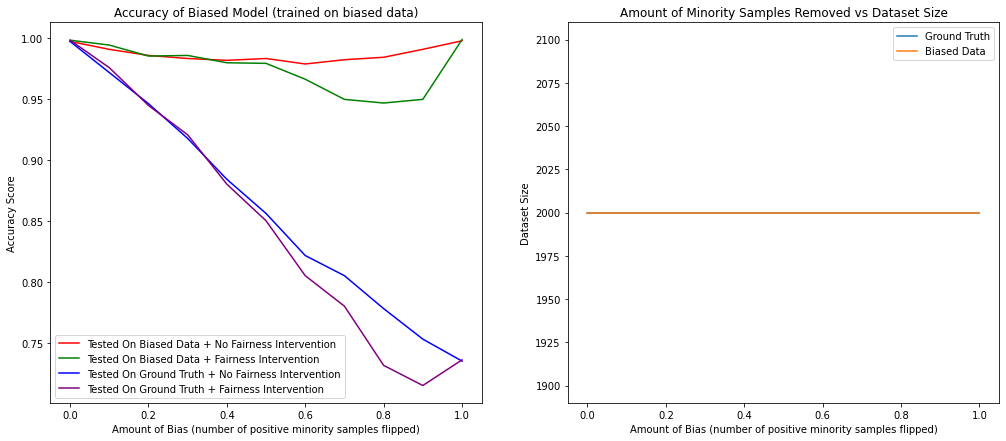

In [88]:
total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                    accuracy_on_biased_mitigated, accuracy_on_true_mitigated,
                    dataset_size_true, dataset_size_bias)